In [ ]:
!rm -rf /root/.cache/kagglehub/datasets/omkargurav

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Veri kümesini indir
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

# İndirilen dosya yapısını kontrol et
print("Veri kümesinin yolu:", path)

100%|██████████| 163M/163M [00:00<00:00, 230MB/s]

Extracting files...


Veri kümesinin yolu: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import tensorflow as tf

# GPU kontrolü
if tf.config.list_physical_devices('GPU'):
    print("GPU kullanılıyor.")
else:
    print("GPU kullanılamıyor. Eğitim CPU üzerinde yapılacak.")

# Veri dizinini belirle
dataset_path = "/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data"
# Veri yolları
with_mask_path = os.path.join(dataset_path, "with_mask")
without_mask_path = os.path.join(dataset_path, "without_mask")

# Klasördeki dosya sayısını hesapla
with_mask_count = len(os.listdir(with_mask_path))
without_mask_count = len(os.listdir(without_mask_path))

# Sonuçları yazdır
print(f"With Mask Path: {with_mask_path} ({with_mask_count} görüntü)")
print(f"Without Mask Path: {without_mask_path} ({without_mask_count} görüntü)")

# Eğitim ve test klasörlerini oluştur
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")
val_dir = os.path.join(dataset_path, "val")

# Eğitim ve test verilerini ayır
all_with_mask = os.listdir(with_mask_path)
all_without_mask = os.listdir(without_mask_path)

train_with_mask, test_with_mask = train_test_split(all_with_mask, test_size=0.1, random_state=42)
train_with_mask_2, val_with_mask_2 = train_test_split(train_with_mask, test_size=0.2, random_state=42)
train_without_mask, test_without_mask = train_test_split(all_without_mask, test_size=0.1, random_state=42)
train_without_mask_2, val_without_mask_2 = train_test_split(train_without_mask, test_size=0.2, random_state=42)


# Eğitim ve test dizinlerine verileri taşıma
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for category, data in zip(["with_mask", "without_mask"], [train_with_mask_2, train_without_mask_2]):
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    for img in data:
        os.rename(os.path.join(dataset_path, category, img), os.path.join(train_dir, category, img))

for category, data in zip(["with_mask", "without_mask"], [val_with_mask_2, val_without_mask_2]):
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    for img in data:
        os.rename(os.path.join(dataset_path, category, img), os.path.join(val_dir, category, img))

for category, data in zip(["with_mask", "without_mask"], [test_with_mask, test_without_mask]):
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    for img in data:
        os.rename(os.path.join(dataset_path, category, img), os.path.join(test_dir, category, img))



# ImageDataGenerator ile veri artırımı
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Veri yükleyicileri
target_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_test_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# DenseNet121 Modeli
base_model_dense = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_dense.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # İki sınıf: Maskeli ve Masksiz

model_dense = Model(inputs=base_model_dense.input, outputs=predictions)
model_dense.summary()

# MobileNetV1 Modeli
base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # İki sınıf: Maskeli ve Masksiz

model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions)
model_mobilenet.summary()

# Eğitim Parametreleri
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)



GPU kullanılıyor.
With Mask Path: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data/with_mask (3725 görüntü)
Without Mask Path: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data/without_mask (3828 görüntü)
Found 5437 images belonging to 2 classes.
Found 1360 images belonging to 2 classes.
Found 756 images belonging to 2 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,406,978 (28.26 MB)

 Trainable params: 7,323,330 (27.94 MB)

 Non-trainable params: 83,648 (326.75 KB)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,598,338 (13.73 MB)

 Trainable params: 3,576,450 (13.64 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [4]:
from tensorflow.keras.models import load_model

# DenseNet121 Modeli için optimizer
optimizer_dense = Adam(learning_rate=0.001)
model_dense.compile(optimizer=optimizer_dense, loss='categorical_crossentropy', metrics=['accuracy'])

history_dense = model_dense.fit(
    train_generator,
    validation_data=val_test_generator,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

try:
    model_dense.save('/content/drive/MyDrive/Yapay Sinir Ağları/densenet121_model.h5')
    print("Model başarıyla kaydedildi!")
except Exception as e:
    print("Model kaydedilemedi!")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 73/170 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.8618 - loss: 0.2914

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


170/170 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.9057 - loss: 0.2160 - val_accuracy: 0.7154 - val_loss: 3.2817 - learning_rate: 0.0010
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 62s 351ms/step - accuracy: 0.9765 - loss: 0.0710 - val_accuracy: 0.9037 - val_loss: 0.4042 - learning_rate: 0.0010
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 345ms/step - accuracy: 0.9874 - loss: 0.0397 - val_accuracy: 0.8184 - val_loss: 1.4443 - learning_rate: 0.0010
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 62s 351ms/step - accuracy: 0.9796 - loss: 0.0563 - val_accuracy: 0.9772 - val_loss: 0.0905 - learning_rate: 0.0010
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 62s 348ms/step - accuracy: 0.9870 - loss: 0.0445 - val_accuracy: 0.9831 - val_loss: 0.0805 - learning_rate: 0.0010
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 345ms/step - accuracy: 0.9866 - loss: 0.0377 - val_accuracy: 0.9875 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 62s 349ms/step - accuracy: 0.9861 - l

Model başarıyla kaydedildi!


In [5]:
# MobileNet Modeli için optimizer
optimizer_mobilenet = Adam(learning_rate=0.001)
model_mobilenet.compile(optimizer=optimizer_mobilenet, loss='categorical_crossentropy', metrics=['accuracy'])

history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=val_test_generator,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

try:
    model_mobilenet.save('/content/drive/MyDrive/Yapay Sinir Ağları/mobilenet_model.h5')
    print("Model başarıyla kaydedildi!")
except Exception as e:
    print("Model kaydedilemedi!")

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 111s 456ms/step - accuracy: 0.9323 - loss: 0.1549 - val_accuracy: 0.7500 - val_loss: 1.2194 - learning_rate: 0.0010
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 60s 342ms/step - accuracy: 0.9884 - loss: 0.0463 - val_accuracy: 0.9574 - val_loss: 0.1750 - learning_rate: 0.0010
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 344ms/step - accuracy: 0.9913 - loss: 0.0284 - val_accuracy: 0.9706 - val_loss: 0.1174 - learning_rate: 0.0010
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 343ms/step - accuracy: 0.9912 - loss: 0.0295 - val_accuracy: 0.9846 - val_loss: 0.0381 - learning_rate: 0.0010
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 60s 341ms/step - accuracy: 0.9926 - loss: 0.0219 - val_accuracy: 0.9882 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 342ms/step - accuracy: 0.9944 - loss: 0.0177 - val_accuracy: 0.9272 - val_loss: 0.3876 - learning_rate: 0.0010
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 343ms/step - accur

Model başarıyla kaydedildi!


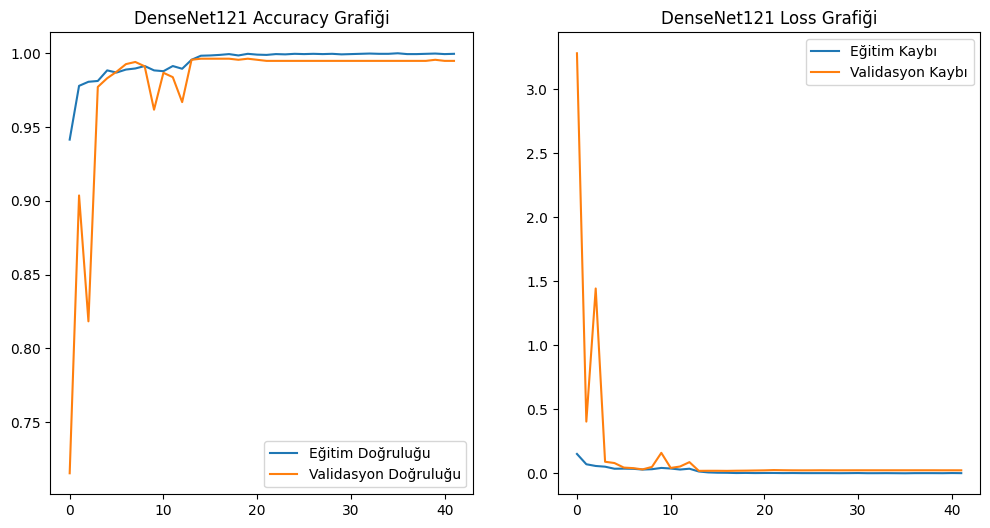

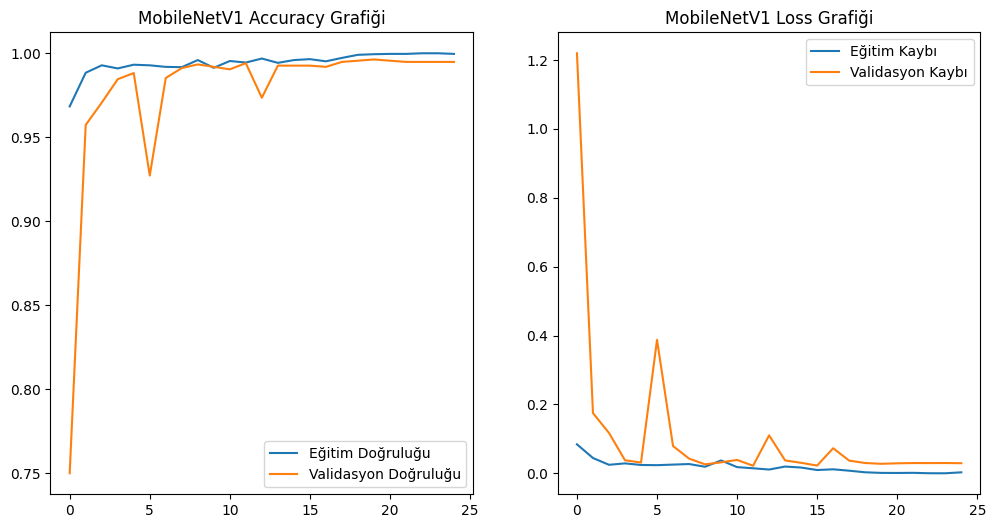

In [10]:
# Eğitim Sonuçlarının Görselleştirilmesi

def plot_training(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Eğitim Doğruluğu')
    plt.plot(val_acc, label='Validasyon Doğruluğu')
    plt.title(f'{title} Accuracy Grafiği')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Eğitim Kaybı')
    plt.plot(val_loss, label='Validasyon Kaybı')
    plt.title(f'{title} Loss Grafiği')
    plt.legend()
    plt.show()

plot_training(history_dense, "DenseNet121")
plot_training(history_mobilenet, "MobileNetV1")

# **Model Yorumları**
# **DenseNet121 Modeli**
* **Accuracy (Doğruluk) Grafiği:**
Eğitim doğruluğu (mavi) istikrarlı bir şekilde artarak neredeyse %100 seviyesine ulaşıyor.
Validasyon doğruluğu (turuncu) başlarda dalgalı olsa da, eğitim doğruluğuna yakın bir seviyeye ulaşıp sabitleniyor (%98 - %99 civarında).
Validasyon doğruluğunun ani dalgalanmalar yaşaması overfitting (aşırı öğrenme) ihtimalini düşündürüyor.
* **Loss (Kayıp) Grafiği:**
Eğitim kaybı zamanla düzenli olarak azalıyor, yani model hatalarını minimize etmeyi başarıyor.
Validasyon kaybı ise başlangıçta çok dalgalı ve yüksek, ancak zamanla düşüyor ve belirli bir noktada sabitleniyor.
Validasyon kaybının dalgalı olması, modelin bazı epoch'larda doğrulama verisi üzerinde kötü performans gösterdiğini ve tam anlamıyla genel bir genelleme yapamadığını gösterebilir.


# **MobileNetV1 Modeli**
* **Accuracy (Doğruluk) Grafiği:**
Eğitim doğruluğu hızla artarak %100'e yakın bir seviyeye ulaşıyor.
Validasyon doğruluğu %99 civarında sabitleniyor, yani model validasyon verisinde de çok iyi bir performans gösteriyor.
Validasyon doğruluğu, DenseNet121'e kıyasla daha az dalgalı, bu da MobileNetV1'in daha stabil öğrenme süreci geçirdiğini gösteriyor.
* **Loss (Kayıp) Grafiği:**
Eğitim kaybı hızla azalıyor ve neredeyse sıfıra ulaşıyor, yani model eğitim verisi üzerinde neredeyse hiç hata yapmıyor.
Validasyon kaybı ise çok düşük seviyelerde sabitlenmiş, yani model validasyon verisinde de başarılı.
MobileNetV1'in validasyon kaybı DenseNet121'e kıyasla daha az dalgalanıyor, bu da modelin genelleme yeteneğinin daha iyi olabileceğini gösteriyor.


---

# **Genel Değerlendirme**

* DenseNet121 modeli, eğitimde yüksek doğruluk sağlasa da validasyon doğruluğunun dalgalı olması overfitting riskini gösteriyor. Daha fazla düzenleme yöntemi (örneğin dropout, veri artırma) uygulanabilir.
* MobileNetV1 modeli, hem eğitim hem de validasyon süreçlerinde daha stabil bir performans gösteriyor. Overfitting daha az görünüyor ve model daha iyi genelleme yapabiliyor gibi görünüyor.
* MobileNetV1, hafif ve hızlı bir model olduğu için haber işleme gibi gerçek zamanlı uygulamalar için daha uygun olabilir. Eğer model seçimi yapıyorsan, MobileNetV1 daha dengeli bir seçim olabilir.

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


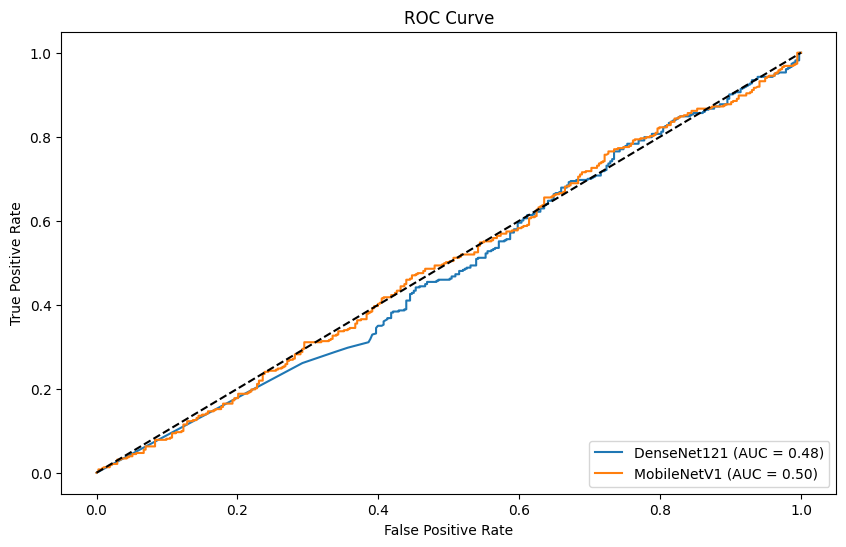

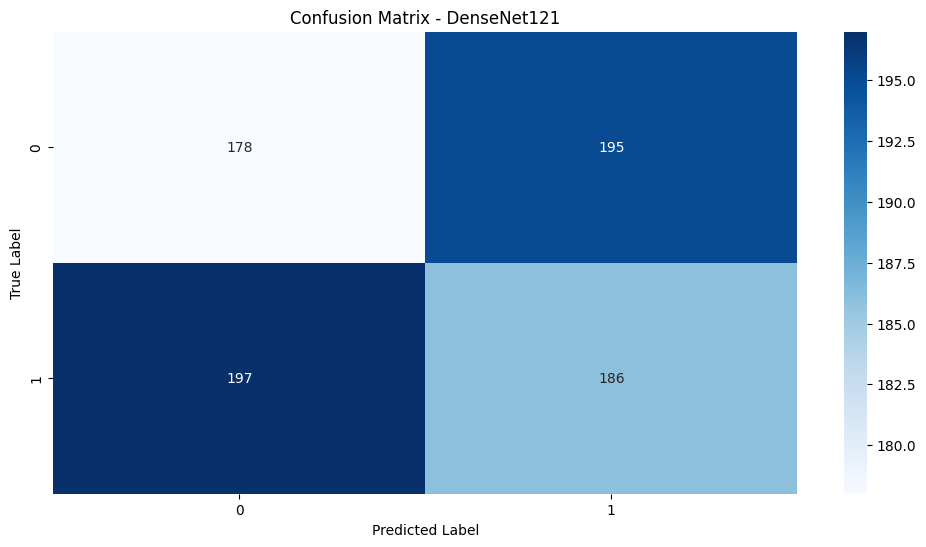

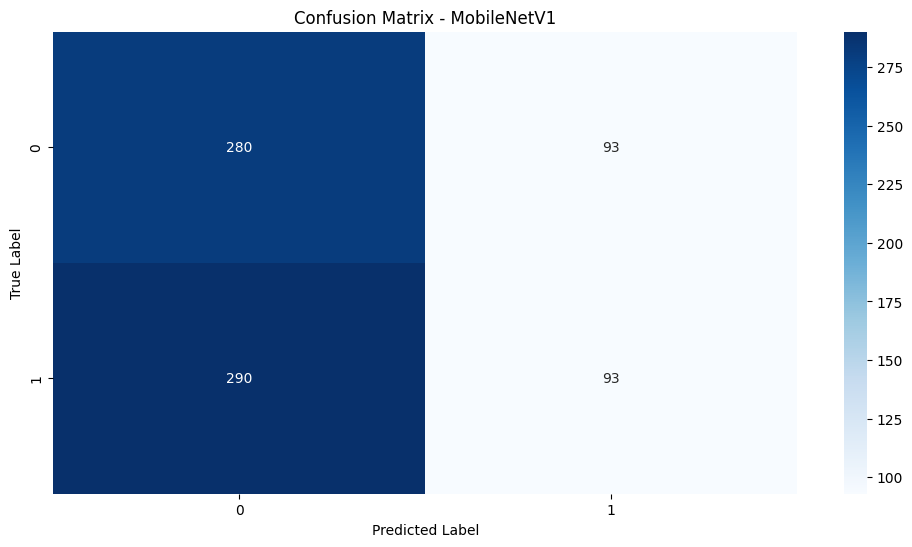


DenseNet121 Model Metrics:
Accuracy: 0.4815
Precision: 0.4882
Recall: 0.4856
Specificity: 0.4772
F1-Score: 0.4869

MobileNetV1 Model Metrics:
Accuracy: 0.4934
Precision: 0.5000
Recall: 0.2428
Specificity: 0.7507
F1-Score: 0.3269

Classification Report - DenseNet121
              precision    recall  f1-score   support

   with_mask       0.47      0.48      0.48       373
without_mask       0.49      0.49      0.49       383

    accuracy                           0.48       756
   macro avg       0.48      0.48      0.48       756
weighted avg       0.48      0.48      0.48       756


Classification Report - MobileNetV1
              precision    recall  f1-score   support

   with_mask       0.49      0.75      0.59       373
without_mask       0.50      0.24      0.33       383

    accuracy                           0.49       756
   macro avg       0.50      0.50      0.46       756
weighted avg       0.50      0.49      0.46       756



In [11]:
# Test set üzerinde tahmin
best_model_dense = model_dense
best_model_mobilenet = model_mobilenet

# Tahminler (inference) için test verisini yükleyin
#test_generator = test_datagen.flow_from_directory(
#    test_dir,
#    target_size=target_size,
#    batch_size=batch_size,
#    class_mode='categorical',
#    shuffle=False
#)

# DenseNet Modeli ile Tahmin
pred_dense = best_model_dense.predict(test_generator)
y_pred_dense = np.argmax(pred_dense, axis=1)
y_true = test_generator.classes

# MobileNet Modeli ile Tahmin
pred_mobilenet = best_model_mobilenet.predict(test_generator)
y_pred_mobilenet = np.argmax(pred_mobilenet, axis=1)

# ROC ve AUC Hesaplama
fpr_dense, tpr_dense, _ = roc_curve(y_true, pred_dense[:, 1])
roc_auc_dense = auc(fpr_dense, tpr_dense)

fpr_mobilenet, tpr_mobilenet, _ = roc_curve(y_true, pred_mobilenet[:, 1])
roc_auc_mobilenet = auc(fpr_mobilenet, tpr_mobilenet)

# ROC Eğrisi Çizimi
plt.figure(figsize=(10, 6))
plt.plot(fpr_dense, tpr_dense, label=f'DenseNet121 (AUC = {roc_auc_dense:.2f})')
plt.plot(fpr_mobilenet, tpr_mobilenet, label=f'MobileNetV1 (AUC = {roc_auc_mobilenet:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix Hesaplama ve Çizim
conf_matrix_dense = confusion_matrix(y_true, y_pred_dense)
conf_matrix_mobilenet = confusion_matrix(y_true, y_pred_mobilenet)

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix_dense, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - DenseNet121')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix_mobilenet, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - MobileNetV1')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Metriklerin Hesaplanması
for model_name, y_pred in zip(['DenseNet121', 'MobileNetV1'], [y_pred_dense, y_pred_mobilenet]):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)

    print(f"\n{model_name} Model Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Classification Report (isteğe bağlı detaylı rapor)
print("\nClassification Report - DenseNet121")
print(classification_report(y_true, y_pred_dense, target_names=test_generator.class_indices.keys()))

print("\nClassification Report - MobileNetV1")
print(classification_report(y_true, y_pred_mobilenet, target_names=test_generator.class_indices.keys()))

# **Test Yorumları**

# **Model Performans Analizi ve Yorumları**
Verilen DenseNet121 ve MobileNetV1 modellerinin performansını değerlendirdiğimizde, her iki modelin de zayıf performans gösterdiği görülüyor. Bu durumu hem ROC eğrisi, hem karışıklık matrisi, hem de sınıflandırma raporlarından anlamak mümkün.

# **ROC Curve (AUC Skoru)**

* DenseNet121 için AUC = 0.48, MobileNetV1 için AUC = 0.50.
* AUC değeri 0.50'ye yakın olan bir model, rastgele tahmin yapan bir modelle eşdeğerdir.
* Burada DenseNet121, rastgele tahminden bile kötü sonuç veriyor (0.48 AUC).
* MobileNetV1, tam anlamıyla rastgele tahminde bulunan bir model gibi (0.50 AUC).
* Bu sonuçlar, her iki modelin de tahmin gücünün düşük olduğunu ve model seçiminde veya veri işleme aşamalarında sorun olabileceğini gösteriyor.



# **Confusion Matrix**

# **DenseNet121 Confusion Matrix Analizi**
* Pozitif (without_mask) ve negatif (with_mask) sınıflarına bakıldığında çok fazla yanlış tahmin var.
* 197 yanlış negatif (FN) ve 195 yanlış pozitif (FP) bulunuyor.
* Doğru tahmin edilenler (TP = 186, TN = 178) sayıca yetersiz.
* Model, sınıflar arasında rastgele karar veriyormuş gibi görünüyor.

# **MobileNetV1 Confusion Matrix Analizi**
* Çok fazla yanlış negatif var (290 FN).
* Çok az doğru pozitif tahmin yapıyor (93 TP).
* Özellikle "without_mask" sınıfını tanımakta zorlanıyor.
* Spesifiklik değeri (0.75) yüksek, yani "with_mask" sınıfını iyi tespit ediyor, ancak diğer sınıfı çok kötü ayırt ediyor.

---
* Genel olarak, her iki model de dengesiz tahminler yapıyor ve gerçek veride iyi genelleme yapamıyor.
---

# **Model Metriği Karşılaştırması**
# **DenseNet121 Metrikleri**
* Accuracy (Doğruluk): 0.4815 → Rastgele tahminle benzer.
* Precision (Kesinlik): 0.4882 → Yanlış pozitif oranı yüksek.
* Recall (Duyarlılık): 0.4856 → Gerçek pozitifleri bulma konusunda başarısız.
* F1-Score: 0.4869 → Genel denge zayıf.

# **MobileNetV1 Metrikleri**
* Accuracy (Doğruluk): 0.4934 → Yine rastgele tahmin ile neredeyse aynı.
* Precision (Kesinlik): 0.5000 → Doğru tahmin oranı şans düzeyinde.
* Recall (Duyarlılık): 0.2428 → Çok düşük, yani birçok gerçeği kaçırıyor.
* Specificity: 0.7507 → "With_mask" sınıfını iyi tanıyor ama "without_mask" sınıfında kötü.
* F1-Score: 0.3269 → Genel olarak kötü bir denge var.
---
MobileNetV1, özellikle "without_mask" sınıfını doğru tahmin edemediği için dengesiz bir model gibi duruyor. DenseNet121 ise neredeyse rastgele tahmin yapıyor.
---

---
📌 Sonuçlar kötü ve bu modeller gerçek veri üzerinde başarılı tahminler yapamıyor.

📌 ROC eğrisi, AUC değerleri ve karışıklık matrisleri, modellerin rastgele tahmin yaptığını gösteriyor.

📌 DenseNet121 tamamen başarısız ve rastgele karar veriyor.

📌 MobileNetV1, "without_mask" sınıfını tespit etmede büyük sorun yaşıyor.
